#### Name：Long-Read DataAnalysis Evaluation
#### People：Ke Liu

In [1]:
import os
import subprocess as sp
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import time
import matplotlib.font_manager as font_manager
font_manager.fontManager.addfont('/home/qukun/liuke/miniconda3/fonts/Arial.ttf')
mpl.rcParams['font.family'] = ['Arial'] 

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.serif'] = ['Arial']

In [3]:
def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

In [4]:
def merge(intervals):
        """
        :param intervals: List[List[int]]
        :return: List[List[int]]
        """
        intervals.sort(key=lambda x: x[0])
        merged = []
        for interval in intervals:
            if not merged or merged[-1][-1] < interval[0]:
                merged.append(interval)
            else:
                merged[-1][-1] = max(merged[-1][-1], interval[-1])
        return merged

##### 1.1 基本参数

In [5]:
dataset_list = ['dataset1','dataset2','dataset3']
prop_dict = {'20.00':0,'20.10':10,'20.20':20,'20.30':30,'20.40':40,'20.50':50}
meancov_dict = {'05':5,'10':10,'15':15,'20':20,'25':25,'30':30,'35':35,'40':40,'45':45,'50':50}
palette_nanopore = {'cresil': '#9146ff', 
                    'ecc_finder_map': '#e66760', 
                    'eccDNA_RCA_nanopore':'#1da1f2', 
                    'nanocircle': '#99cc33',
                    'ecc_finder_asm': '#FFB7B7'
                   }
nanopore_tools = ['ecc_finder_map', 'ecc_finder_asm', 'eccDNA_RCA_nanopore', 'nanocircle','cresil']
nanopore_labels = {'cresil':'CReSIL', 
                   'ecc_finder_map':'ecc_finder(map-ont)', 
                   'eccDNA_RCA_nanopore':'eccDNA_RCA_nanopore', 
                   'nanocircle':'NanoCircle',
                   'ecc_finder_asm':'ecc_finder(asm-ont)'}
cond_dict = {'p':'pos', 'n':'neg'}

##### 1.2 计算各项参数

In [6]:
for tool in nanopore_tools:
    for data in dataset_list:
        for sample in {**prop_dict,**meancov_dict}:
            pos_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+sample+'.'+tool+'.pos.mcoords'
            neg_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+sample+'.'+tool+'.neg.mcoords'
            if os.path.exists(pos_path):
                ##筛选大于90%的值
                locals()[data+'_'+sample+'_'+tool+'_pos'] = pd.read_csv(pos_path,sep='\t',header=None,index_col=None)
                pos_temp = locals()[data+'_'+sample+'_'+tool+'_pos']
                locals()[data+'_'+sample+'_'+tool+'_pos_select'] = pd.DataFrame(pos_temp[(pos_temp[9]>90)&(pos_temp[10]>90)])
                
                locals()[data+'_'+sample+'_'+tool+'_neg'] = pd.read_csv(neg_path,sep='\t',header=None,index_col=None)
                neg_temp = locals()[data+'_'+sample+'_'+tool+'_neg']
                locals()[data+'_'+sample+'_'+tool+'_neg_select'] = pd.DataFrame(neg_temp[(neg_temp[9]>90)&(neg_temp[10]>90)])

##### 合并嵌合片段

In [7]:
s =time.time()
for tool in  nanopore_tools:
    for data in dataset_list:
        for sample in {**prop_dict,**meancov_dict}:
            for cond in cond_dict:
                locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'] = pd.DataFrame(columns=range(13))
                chimeric_temp = locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]]
                chimeric_temp = chimeric_temp[chimeric_temp[11].str.contains('c'+cond)]
                simple_temp = locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]]
                simple_temp = simple_temp[simple_temp[11].str.contains('s'+cond)]
                chimeric_temp.insert(13,13,chimeric_temp[11].astype(str)+chimeric_temp[12].astype(str))
                for i in chimeric_temp[13].unique():
                    temp = chimeric_temp[chimeric_temp[13]==i]
                    length_a = list(temp[7])[0];length_b = list(temp[8])[0]
                    id_a = list(temp[11])[0];id_b = list(temp[12])[0]
                    se1 = []; se2 = []
                    for j in temp.index:
                        if (temp.loc[j,0]<temp.loc[j,1]): se1.append([temp.loc[j,0],temp.loc[j,1]])
                        else: se1.append([temp.loc[j,1],temp.loc[j,0]])
                        if (temp.loc[j,2]<temp.loc[j,3]):se2.append([temp.loc[j,2],temp.loc[j,3]])
                        else: se2.append([temp.loc[j,3],temp.loc[j,2]])
                    intersect_a = abs(pd.DataFrame(merge(se1))[1].sum()-pd.DataFrame(merge(se1))[0].sum())
                    intersect_b = abs(pd.DataFrame(merge(se2))[1].sum()-pd.DataFrame(merge(se2))[0].sum())
                    locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'].loc[i] = [0,0,0,0,intersect_a,intersect_b,0,length_a,length_b,intersect_a*100/length_a,intersect_b*100/length_b,id_a,id_b]
                locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'] = pd.concat([locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'], simple_temp])
                locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge_select'] = locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'][(locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'][9]>90)&(locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'][10]>90)]
print('Time Consumed: {0} min'.format((time.time()-s)/60))

Time Consumed: 120.55290380716323 min


In [9]:
for tool in nanopore_tools:
    for data in dataset_list:
        result_table=pd.DataFrame(columns=['meancov','Tools','TP1','TP2','FP','TN','FN','Sensitivity','Specificity','F1score','PCC','RMSE','JSD'])
        for sample in meancov_dict:
            if os.path.exists(pos_path): 
                fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/fasta/'+data+'.'+sample+'.'+tool+'.fasta'
                locals()[data+'_'+sample+'_'+tool+'_count'] = len(open(fasta_path,'r').readlines())/2
                ## 计算交集和并集
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'] = locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][[5,7,8]]
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'].insert(1,1,locals()[data+'_'+sample+'_'+tool+'_merge_acc'][7] + locals()[data+'_'+sample+'_'+tool+'_merge_acc'][8] - locals()[data+'_'+sample+'_'+tool+'_merge_acc'][5])
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'].columns = ['intersect', 'union', 'a', 'b']
                union = locals()[data+'_'+sample+'_'+tool+'_merge_acc'].union.astype(int)
                intersect = locals()[data+'_'+sample+'_'+tool+'_merge_acc'].intersect.astype(int)
                PCC = scipy.stats.pearsonr(np.array(locals()[data+'_'+sample+'_'+tool+'_merge_acc'].union), np.array(locals()[data+'_'+sample+'_'+tool+'_merge_acc'].intersect))[0]
                RMSE = np.sqrt(np.mean(np.square(union-intersect)))
                JSD = JS_divergence(union, intersect)
                ##被鉴定出来的结果
                
                TP1=len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][11].unique())
                TP2=len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].unique())
                FP=locals()[data+'_'+sample+'_'+tool+'_count']-len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].unique())
                FN=10000-len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][11].unique())
                TN=10000-len(locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'][11].unique())
                Specificity = TN/(TN+FP)
                if (TP1!=0):
                    Recall = TP1/(TP1+FN)
                    Precision = TP2/(TP2+FP)
                    F1score = 2 * Precision * Recall / (Precision + Recall)
                else:
                    Recall = Precision = F1score = 0
                result_table.loc[meancov_dict[sample]]=[meancov_dict[sample],tool,TP1,TP2,FP,TN,FN,Recall,Specificity,F1score, PCC, RMSE, JSD]  
        locals()[data+'_'+tool+'_merge_cresult']=result_table

for tool in nanopore_tools:
    for data in dataset_list:
        result_table=pd.DataFrame(columns=['prop','Tools','TP1','TP2','FP','TN','FN','Sensitivity','Specificity','F1score','PCC','RMSE','JSD'])
        for sample in prop_dict:
            if os.path.exists(pos_path): 
                fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/fasta/'+data+'.'+sample+'.'+tool+'.fasta'
                locals()[data+'_'+sample+'_'+tool+'_count'] = len(open(fasta_path,'r').readlines())/2
                ## 计算交集和并集
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'] = locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][[5,7,8]]
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'].insert(1,1,locals()[data+'_'+sample+'_'+tool+'_merge_acc'][7] + locals()[data+'_'+sample+'_'+tool+'_merge_acc'][8] - locals()[data+'_'+sample+'_'+tool+'_merge_acc'][5])
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'].columns = ['intersect', 'union', 'a', 'b']
                union = locals()[data+'_'+sample+'_'+tool+'_merge_acc'].union.astype(int)
                intersect = locals()[data+'_'+sample+'_'+tool+'_merge_acc'].intersect.astype(int)
                PCC = scipy.stats.pearsonr(np.array(locals()[data+'_'+sample+'_'+tool+'_merge_acc'].union), np.array(locals()[data+'_'+sample+'_'+tool+'_merge_acc'].intersect))[0]
                RMSE = np.sqrt(np.mean(np.square(union-intersect)))
                JSD = JS_divergence(union, intersect)
                ##被鉴定出来的结果
                
                TP1=len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][11].unique())
                TP2=len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].unique())
                FP=locals()[data+'_'+sample+'_'+tool+'_count']-len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].unique())
                FN=10000-len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][11].unique())
                TN=10000-len(locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'][11].unique())
                Specificity = TN/(TN+FP)
                if (TP1!=0):
                    Recall = TP1/(TP1+FN)
                    Precision = TP2/(TP2+FP)
                    F1score = 2 * Precision * Recall / (Precision + Recall)
                else:
                    Recall = Precision = F1score = 0
                result_table.loc[prop_dict[sample]]=[prop_dict[sample],tool,TP1,TP2,FP,TN,FN,Recall,Specificity,F1score, PCC, RMSE, JSD]  
        locals()[data+'_'+tool+'_merge_rresult']=result_table

In [22]:
for tool in ['cresil']:
    for data in dataset_list:
        result_table=pd.DataFrame(columns=['meancov','Tools','TP1','TP2','FP','TN','FN','Sensitivity','Specificity','F1score','PCC','RMSE','JSD'])
        for sample in meancov_dict:
            if os.path.exists(pos_path): 
                txt_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/fasta/'+data+'.'+sample+'.'+tool+'.txt'
                txt=pd.read_csv(txt_path,sep='\t')
                ec_list = txt[txt.eccdna_status=='cyclic'].id
                locals()[data+'_'+sample+'_'+tool+'_count'] = len(ec_list)
                locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'] = locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].isin(ec_list)]
                locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'] = locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'][locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'][12].isin(ec_list)]
                ## 计算交集和并集
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'] = locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][[5,7,8]]
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'].insert(1,1,locals()[data+'_'+sample+'_'+tool+'_merge_acc'][7] + locals()[data+'_'+sample+'_'+tool+'_merge_acc'][8] - locals()[data+'_'+sample+'_'+tool+'_merge_acc'][5])
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'].columns = ['intersect', 'union', 'a', 'b']
                union = locals()[data+'_'+sample+'_'+tool+'_merge_acc'].union.astype(int)
                intersect = locals()[data+'_'+sample+'_'+tool+'_merge_acc'].intersect.astype(int)
                PCC = scipy.stats.pearsonr(np.array(locals()[data+'_'+sample+'_'+tool+'_merge_acc'].union), np.array(locals()[data+'_'+sample+'_'+tool+'_merge_acc'].intersect))[0]
                RMSE = np.sqrt(np.mean(np.square(union-intersect)))
                JSD = JS_divergence(union, intersect)
                ##被鉴定出来的结果
                
                TP1=len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][11].unique())
                TP2=len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].unique())
                FP=locals()[data+'_'+sample+'_'+tool+'_count']-len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].unique())
                FN=10000-len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][11].unique())
                TN=10000-len(locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'][11].unique())
                Specificity = TN/(TN+FP)
                if (TP1!=0):
                    Recall = TP1/(TP1+FN)
                    Precision = TP2/(TP2+FP)
                    F1score = 2 * Precision * Recall / (Precision + Recall)
                else:
                    Recall = Precision = F1score = 0
                result_table.loc[meancov_dict[sample]]=[meancov_dict[sample],tool,TP1,TP2,FP,TN,FN,Recall,Specificity,F1score, PCC, RMSE, JSD]  
        locals()[data+'_'+tool+'_merge_cresult']=result_table

for tool in ['cresil']:
    for data in dataset_list:
        result_table=pd.DataFrame(columns=['prop','Tools','TP1','TP2','FP','TN','FN','Sensitivity','Specificity','F1score','PCC','RMSE','JSD'])
        for sample in prop_dict:
            if os.path.exists(pos_path): 
                txt_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/fasta/'+data+'.'+sample+'.'+tool+'.txt'
                txt=pd.read_csv(txt_path,sep='\t')
                ec_list = txt[txt.eccdna_status=='cyclic'].id
                locals()[data+'_'+sample+'_'+tool+'_count'] = len(ec_list)
                locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'] = locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].isin(ec_list)]
                locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'] = locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'][locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'][12].isin(ec_list)]
                ## 计算交集和并集
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'] = locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][[5,7,8]]
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'].insert(1,1,locals()[data+'_'+sample+'_'+tool+'_merge_acc'][7] + locals()[data+'_'+sample+'_'+tool+'_merge_acc'][8] - locals()[data+'_'+sample+'_'+tool+'_merge_acc'][5])
                locals()[data+'_'+sample+'_'+tool+'_merge_acc'].columns = ['intersect', 'union', 'a', 'b']
                union = locals()[data+'_'+sample+'_'+tool+'_merge_acc'].union.astype(int)
                intersect = locals()[data+'_'+sample+'_'+tool+'_merge_acc'].intersect.astype(int)
                PCC = scipy.stats.pearsonr(np.array(locals()[data+'_'+sample+'_'+tool+'_merge_acc'].union), np.array(locals()[data+'_'+sample+'_'+tool+'_merge_acc'].intersect))[0]
                RMSE = np.sqrt(np.mean(np.square(union-intersect)))
                JSD = JS_divergence(union, intersect)
                ##被鉴定出来的结果
                
                TP1=len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][11].unique())
                TP2=len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].unique())
                FP=locals()[data+'_'+sample+'_'+tool+'_count']-len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][12].unique())
                FN=10000-len(locals()[data+'_'+sample+'_'+tool+'_pos_merge_select'][11].unique())
                TN=10000-len(locals()[data+'_'+sample+'_'+tool+'_neg_merge_select'][11].unique())
                Specificity = TN/(TN+FP)
                if (TP1!=0):
                    Recall = TP1/(TP1+FN)
                    Precision = TP2/(TP2+FP)
                    F1score = 2 * Precision * Recall / (Precision + Recall)
                else:
                    Recall = Precision = F1score = 0
                result_table.loc[prop_dict[sample]]=[prop_dict[sample],tool,TP1,TP2,FP,TN,FN,Recall,Specificity,F1score, PCC, RMSE, JSD]  
        locals()[data+'_'+tool+'_merge_rresult']=result_table

In [119]:
locals()['nanopore_merge_meancov'] = pd.DataFrame(columns=['tools','data','meancov','F1score','Sensitivity','Specificity','PCC','RMSE','JSD'])
i=0
for data in ['dataset1', 'dataset2','dataset3']:
    for tool in nanopore_tools:
        for meancov in meancov_dict:
            pos_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+meancov+'.'+tool+'.pos.mcoords'
            if os.path.exists(pos_path):
                locals()['nanopore_merge_meancov'].loc[i,['tools','data','meancov']] = [tool, data, meancov_dict[meancov]]
                for paras in ['F1score','Sensitivity','Specificity','PCC','RMSE','JSD']:
                    locals()['nanopore_merge_meancov'].loc[i, paras] = locals()[data+'_'+tool+'_merge_cresult'].loc[meancov_dict[meancov], paras]
                i+=1

locals()['nanopore_merge_prop'] = pd.DataFrame(columns=['tools','data','prop','F1score','Sensitivity','Specificity','PCC','RMSE','JSD'])
i=0
for data in ['dataset1','dataset2','dataset3']:
    for tool in nanopore_tools:
        for prop in prop_dict:
            pos_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+prop+'.'+tool+'.pos.mcoords'
            if os.path.exists(pos_path):
                locals()['nanopore_merge_prop'].loc[i,['tools','data','prop']] = [tool, data, prop_dict[prop]]
                for paras in ['F1score','Sensitivity','Specificity','PCC','RMSE','JSD']:
                    locals()['nanopore_merge_prop'].loc[i, paras] = locals()[data+'_'+tool+'_merge_rresult'].loc[prop_dict[prop], paras]
                i+=1

total_nanopore_merge_meancov = pd.DataFrame() 
for data in ['dataset1', 'dataset2', 'dataset3']:
    for meancov in meancov_dict:
        rank_temp = nanopore_merge_meancov[(nanopore_merge_meancov.data==data)&(nanopore_merge_meancov.meancov==meancov_dict[meancov])]
        rank_temp.insert(9,'SS',0)
        for i in rank_temp.index:
            rank_temp.loc[i,'SS'] = (rank_temp.loc[i,'PCC']-rank_temp['PCC'].min())/(rank_temp['PCC'].max()-rank_temp['PCC'].min())
            rank_temp.loc[i,'SS'] += abs((rank_temp.loc[i,'RMSE']-rank_temp['RMSE'].max())/(rank_temp['RMSE'].max()-rank_temp['RMSE'].min()))
            rank_temp.loc[i,'SS'] += abs((rank_temp.loc[i,'JSD']-rank_temp['JSD'].max())/(rank_temp['JSD'].max()-rank_temp['JSD'].min()))
            rank_temp.loc[i,'SS'] /= 3
        total_nanopore_merge_meancov = pd.concat([total_nanopore_merge_meancov, rank_temp])

total_nanopore_merge_prop = pd.DataFrame() 
for data in ['dataset1', 'dataset2', 'dataset3']:
    for prop in prop_dict:
        rank_temp = nanopore_merge_prop[(nanopore_merge_prop.data==data)&(nanopore_merge_prop.prop==prop_dict[prop])]
        rank_temp.insert(9,'SS',0)
        for i in rank_temp.index:
            rank_temp.loc[i,'SS'] = (rank_temp.loc[i,'PCC']-rank_temp['PCC'].min())/(rank_temp['PCC'].max()-rank_temp['PCC'].min())
            rank_temp.loc[i,'SS'] += abs((rank_temp.loc[i,'RMSE']-rank_temp['RMSE'].max())/(rank_temp['RMSE'].max()-rank_temp['RMSE'].min()))
            rank_temp.loc[i,'SS'] += abs((rank_temp.loc[i,'JSD']-rank_temp['JSD'].max())/(rank_temp['JSD'].max()-rank_temp['JSD'].min()))
            rank_temp.loc[i,'SS'] /= 3
        total_nanopore_merge_prop = pd.concat([total_nanopore_merge_prop, rank_temp])   
total_nanopore_merge_meancov.to_csv('/home/qukun/liuke/workspace/benchmark/figure/published/total_nanopore_merge_meancov.csv',sep='\t')
total_nanopore_merge_prop.to_csv('/home/qukun/liuke/workspace/benchmark/figure/published/total_nanopore_merge_prop.csv',sep='\t')

In [7]:
total_nanopore_merge_meancov=pd.read_csv('/home/qukun/liuke/workspace/benchmark/figure/published/total_nanopore_merge_meancov.csv',sep='\t')
total_nanopore_merge_prop=pd.read_csv('/home/qukun/liuke/workspace/benchmark/figure/published/total_nanopore_merge_prop.csv',sep='\t')

In [8]:
nanopore_merge_plot = pd.DataFrame(columns = ['tools','meanSS','meanF1score','stdSS','stdF1score','seSS','seF1score'])
i=0
for tool in nanopore_tools:
    temp = total_nanopore_merge_meancov[(total_nanopore_merge_meancov.tools==tool)&(total_nanopore_merge_meancov.meancov==50)]
    nanopore_merge_plot.loc[i] = [tool,temp.SS.mean(),temp.F1score.mean(),temp.SS.std(),temp.F1score.std(),temp.SS.std()/math.sqrt(len(temp)),temp.F1score.std()/math.sqrt(len(temp))]
    i+=1

In [11]:
nanopore_merge_plot.to_csv('/home/qukun/liuke/workspace/benchmark/figure/published/Figure1C2.csv',index=None)

(-0.05, 1.05)

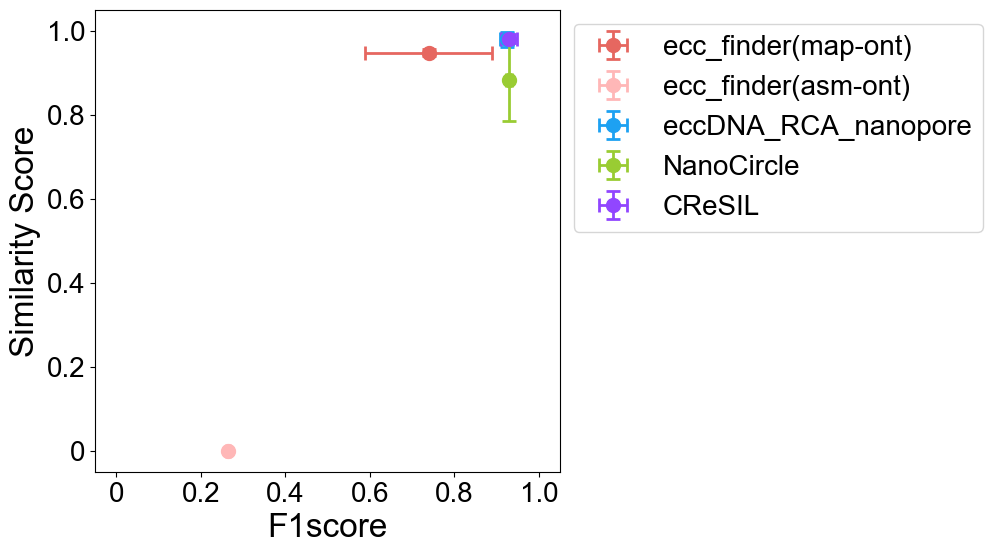

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
for tool in nanopore_tools:
    ax.errorbar(x=nanopore_merge_plot[nanopore_merge_plot.tools==tool].meanF1score, 
                y=nanopore_merge_plot[nanopore_merge_plot.tools==tool].meanSS, 
                xerr=nanopore_merge_plot[nanopore_merge_plot.tools==tool].seF1score, 
                yerr=nanopore_merge_plot[nanopore_merge_plot.tools==tool].seSS, 
                fmt='o', 
                elinewidth=2,
                markersize=10,
                capsize=5,
                capthick=2,
                color=palette_nanopore[tool],
                label=nanopore_labels[tool],
               )
ax.legend(loc=2,bbox_to_anchor=(1,1),fontsize=20)
ax.set_xlabel('F1score',fontsize=24)
ax.set_ylabel('Similarity Score',fontsize=24)
ax.set_xticks([i*0.2 for i in range(6)],[0,0.2,0.4,0.6,0.8,1.0],fontsize=20)
ax.set_yticks([i*0.2 for i in range(6)],[0,0.2,0.4,0.6,0.8,1.0],fontsize=20)
ax.set_xlim(-.05,1.05);ax.set_ylim(-.05,1.05)
plt.savefig('/home/qukun/liuke/workspace/benchmark/figure/published/Figure1C2.pdf', dpi=2000, bbox_inches='tight')

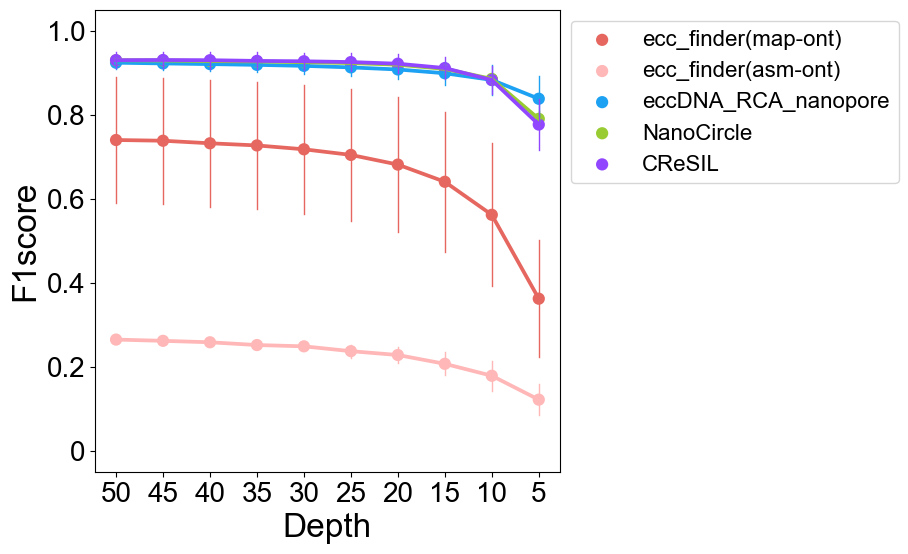

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
for tool in nanopore_tools:
    sns.pointplot(data=total_nanopore_merge_meancov[total_nanopore_merge_meancov.tools==tool], x='meancov',label=nanopore_labels[tool], y='F1score',ax=ax, color=palette_nanopore[tool], errwidth=1, errorbar='se')

ax.legend(loc=2,bbox_to_anchor=(1,1),fontsize=16)
ax.set_xticks(range(10),[5*i for i in range(1,11)], fontsize=20)
ax.set_yticks([0, .2, .4, .6, .8, 1],['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=20)
ax.set_xlabel('Depth',fontsize=24)
ax.set_ylabel('F1score',fontsize=24)
ax.set_xlim(-.45,9.45);ax.set_ylim(-.05,1.05)
ax.invert_xaxis()
plt.savefig('/home/qukun/liuke/workspace/benchmark/figure/published/Figure1D2.pdf', dpi=2000, bbox_inches='tight')

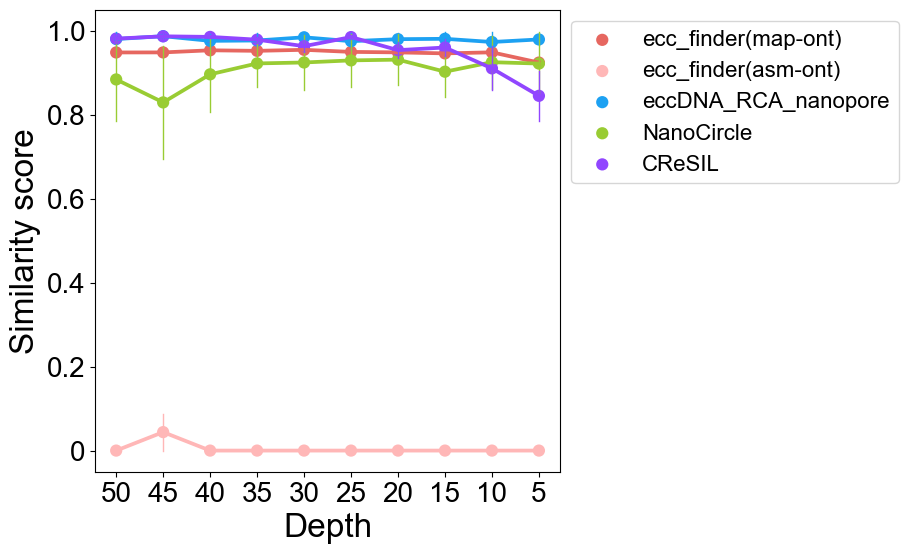

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
for tool in nanopore_tools:
    sns.pointplot(data=total_nanopore_merge_meancov[total_nanopore_merge_meancov.tools==tool], x='meancov',label=nanopore_labels[tool], y='SS',ax=ax, color=palette_nanopore[tool], errwidth=1, errorbar='se')
ax.legend(loc=2,bbox_to_anchor=(1,1),fontsize=16)
ax.set_xticks(range(10),[5*i for i in range(1,11)], fontsize=20)
ax.set_yticks([0, .2, .4, .6, .8, 1],['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=20)
ax.set_xlabel('Depth',fontsize=24)
ax.set_ylabel('Similarity score',fontsize=24)
ax.set_xlim(-.45,9.45);ax.set_ylim(-.05,1.05)
ax.invert_xaxis()
plt.savefig('/home/qukun/liuke/workspace/benchmark/figure/published/sFigure1B2.pdf', dpi=2000, bbox_inches='tight')

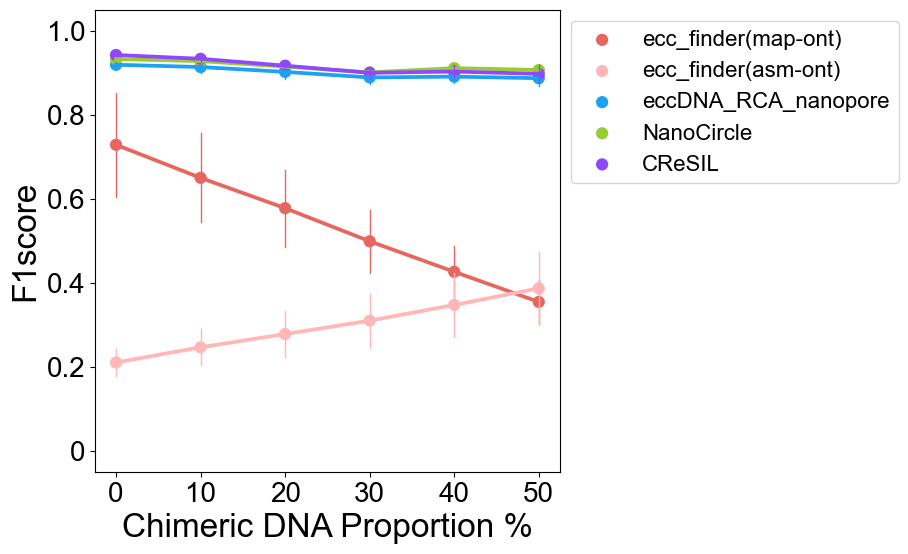

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
for tool in nanopore_tools:
    sns.pointplot(data=total_nanopore_merge_prop[total_nanopore_merge_prop.tools==tool], x='prop',label=nanopore_labels[tool], y='F1score',ax=ax, color=palette_nanopore[tool], errwidth=1, errorbar='se')
ax.invert_xaxis()
ax.legend(loc=2,bbox_to_anchor=(1,1),fontsize=16)
ax.set_xticks(range(10),[10*(i-1) for i in range(1,11)], fontsize=20)
ax.set_yticks([0, .2, .4, .6, .8, 1],['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=20)
ax.set_xlabel('Chimeric DNA Proportion %',fontsize=24)
ax.set_ylabel('F1score',fontsize=24)
ax.set_xlim(-.25,5.25);ax.set_ylim(-.05,1.05)
plt.savefig('/home/qukun/liuke/workspace/benchmark/figure/published/Figure1F2.pdf', dpi=2000, bbox_inches='tight')

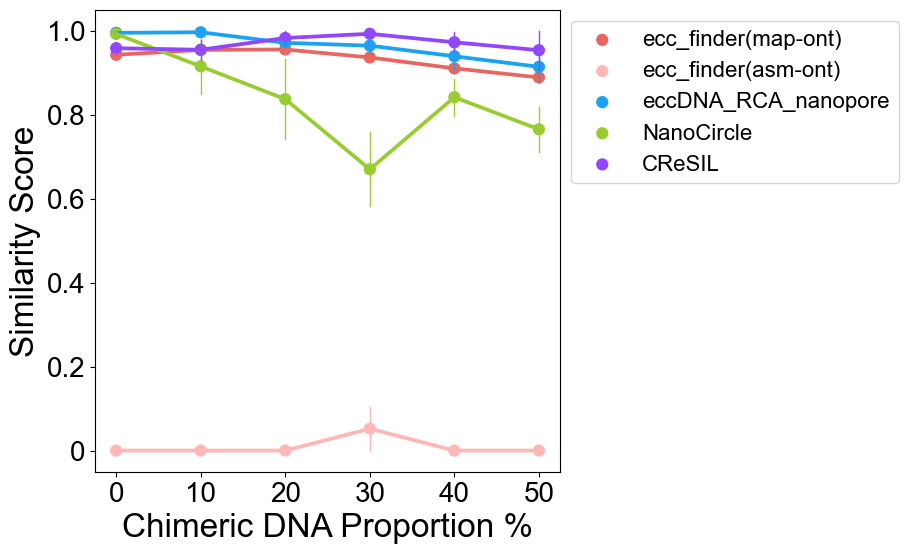

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
for tool in nanopore_tools:
    sns.pointplot(data=total_nanopore_merge_prop[total_nanopore_merge_prop.tools==tool], x='prop',label=nanopore_labels[tool], y='SS',ax=ax, color=palette_nanopore[tool], errwidth=1, errorbar='se')
ax.invert_xaxis()
ax.legend(loc=2,bbox_to_anchor=(1,1),fontsize=16)
ax.set_xticks(range(10),[10*(i-1) for i in range(1,11)], fontsize=20)
ax.set_yticks([0, .2, .4, .6, .8, 1],['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=20)
ax.set_xlabel('Chimeric DNA Proportion %',fontsize=24)
ax.set_ylabel('Similarity Score',fontsize=24)
ax.set_xlim(-.25,5.25);ax.set_ylim(-.05,1.05)
plt.savefig('/home/qukun/liuke/workspace/benchmark/figure/published/sFigure1C2.pdf', dpi=2000, bbox_inches='tight')

In [17]:
duplicate_table = pd.DataFrame(columns=['meancov','tools','dr'])
i=0
for tool in nanopore_tools:
    for dataset in dataset_list:
        for meancov in meancov_dict:
            fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/fasta/'+dataset+'.'+meancov+'.'+tool+'.fasta'
            if os.path.exists(fasta_path): 
                duplicate_table.loc[i] = [meancov_dict[meancov],tool,locals()[dataset+'_'+tool+'_merge_cresult'].loc[meancov_dict[meancov],'TP2']/locals()[dataset+'_'+tool+'_merge_cresult'].loc[meancov_dict[meancov],'TP1']]
                i+=1
duplicate_table.to_csv('/home/qukun/liuke/workspace/benchmark/figure/published/duplicate_table_nanopore.csv',sep='\t')

KeyError: 'dataset1_ecc_finder_map_merge_cresult'

In [133]:
nanopore_tools_renew=[]
nanopore_palette_renew=[]
for i in nanopore_tools:
    nanopore_tools_renew = nanopore_tools_renew + [nanopore_labels[i]]
    nanopore_palette_renew = nanopore_palette_renew + [palette_nanopore[i]]
nanopore_palette = dict(zip(nanopore_tools_renew,nanopore_palette_renew))
duplicate_table.insert(duplicate_table.shape[1],'Tools',duplicate_table.apply(lambda x: nanopore_labels[x.tools], axis=1))
duplicate_table.insert(0,'logdr',np.log2(duplicate_table.dr))

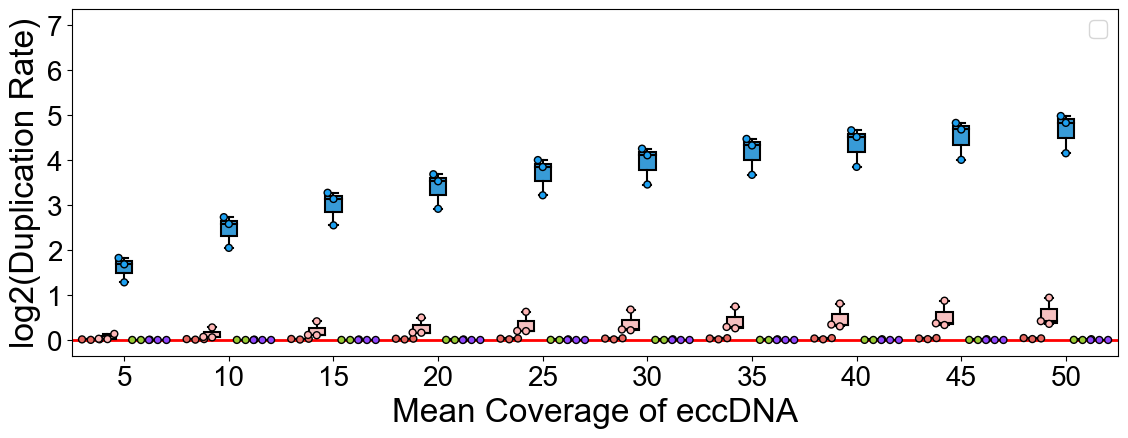

In [201]:
fig, ax = plt.subplots(figsize=(13.5,4.5))
sns.boxplot(duplicate_table,x='meancov',y='logdr',hue='Tools',color='r',hue_order=nanopore_tools_renew, palette=nanopore_palette,ax=ax,dodge=True,
            capprops={'color':'black'},
            whiskerprops={'color':'black'},
            medianprops={'color':'black'},
            boxprops={'edgecolor':'black'},)
sns.swarmplot(duplicate_table,x='meancov',y='logdr',hue='Tools',edgecolor='black',linewidth=1,hue_order=nanopore_tools_renew, palette=nanopore_palette,ax=ax,dodge=True,size=5)
ax.legend([],loc=1,bbox_to_anchor=(1,1),fontsize=16)
ax.set_xlabel('Mean Coverage of eccDNA',fontsize=24)
ax.set_ylabel('log2(Duplication Rate)',fontsize=24)
ax.set_xticks(range(10),[i*5 for i in range(1,11)],fontsize=20)
ax.set_yticks(range(0,8,1),range(0,8,1),fontsize=20)
plt.axhline(y=0,linestyle='-',color='r',linewidth=2)
ax.set_xlim(-.5,9.5);ax.set_ylim(-.35,7.35)
plt.savefig('/home/qukun/liuke/workspace/benchmark/figure/published/Figure1E2.pdf', dpi=2000, bbox_inches='tight')

In [18]:
simple_chimeric = pd.DataFrame(columns=['prop','tools','dataset','simple','chimeric'])
i=0
for tool in nanopore_tools:
    for dataset in dataset_list:
        for prop in prop_dict:
            fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/fasta/'+dataset+'.'+prop+'.'+tool+'.fasta'
            if os.path.exists(fasta_path):
                simple = len(locals()[dataset+'_'+prop+'_'+tool+'_pos_merge_select'][11][locals()[dataset+'_'+prop+'_'+tool+'_pos_merge_select'][11].str.contains('sp')].unique())
                chimeric = len(locals()[dataset+'_'+prop+'_'+tool+'_pos_merge_select'][11][locals()[dataset+'_'+prop+'_'+tool+'_pos_merge_select'][11].str.contains('cp')].unique())
                if prop_dict[prop]!=0:
                    simple_chimeric.loc[i] = [prop_dict[prop],tool,dataset,simple/(10000-100*prop_dict[prop]),chimeric/(100*prop_dict[prop])]
                    i+=1
                else:
                    simple_chimeric.loc[i] = [prop_dict[prop],tool,dataset,simple/(10000-100*prop_dict[prop]),0]
                    i+=1
simple_chimeric.to_csv('/home/qukun/liuke/workspace/benchmark/figure/published/simple_chimeric_recall_nanopore.csv',sep='\t')

KeyError: 'dataset1_20.00_ecc_finder_map_pos_merge_select'

In [3]:
simple_chimeric = pd.read_csv('/home/qukun/liuke/workspace/benchmark/figure/published/simple_chimeric_recall_nanopore.csv',sep='\t')

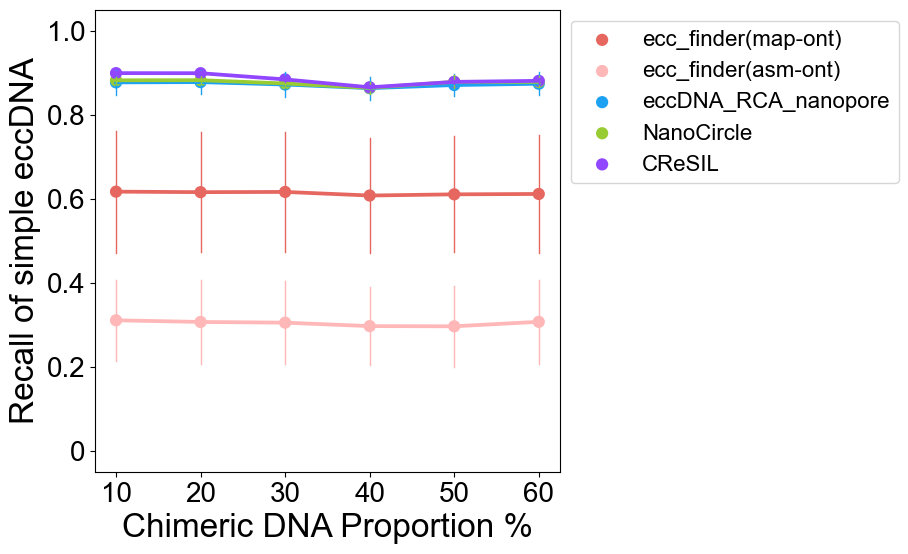

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
for tool in nanopore_tools:
    sns.pointplot(simple_chimeric[simple_chimeric.tools==tool],x='prop',y='simple', ax=ax,label=nanopore_labels[tool],color=palette_nanopore[tool], errwidth=1, errorbar='se')
ax.invert_xaxis()
ax.legend(loc=2,bbox_to_anchor=(1,1),fontsize=16)
ax.set_xticks(range(10),[10*i for i in range(1,11)], fontsize=20)
ax.set_yticks([0, .2, .4, .6, .8, 1],['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=20)
ax.set_xlabel('Chimeric DNA Proportion %',fontsize=24)
ax.set_ylabel('Recall of simple eccDNA',fontsize=24)
ax.set_xlim(-.25,5.25);ax.set_ylim(-.05,1.05)
plt.savefig('/home/qukun/liuke/workspace/benchmark/figure/published/sFigure1E1.pdf', dpi=2000, bbox_inches='tight')

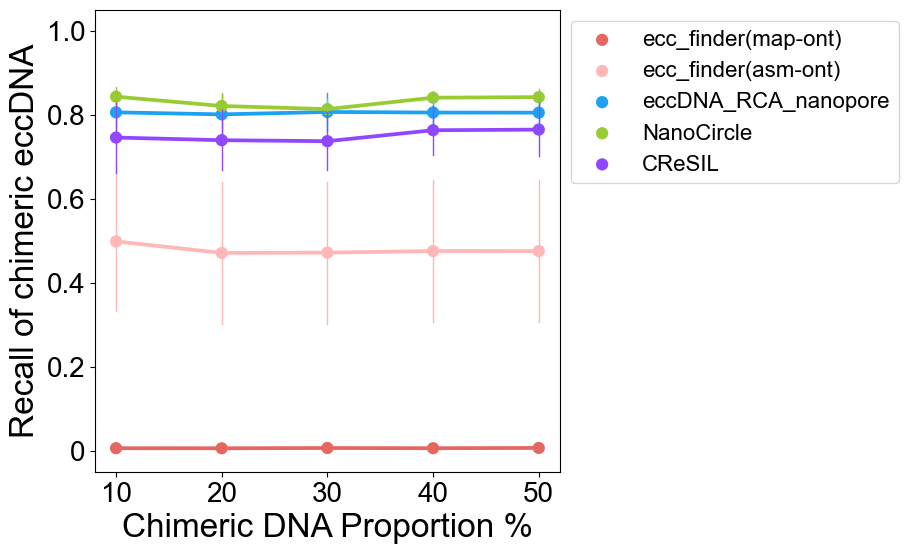

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
for tool in nanopore_tools:
    sns.pointplot(simple_chimeric[(simple_chimeric.tools==tool)&(simple_chimeric.prop!=0)],x='prop',y='chimeric', ax=ax,label=nanopore_labels[tool], color=palette_nanopore[tool], errwidth=1, errorbar='se')
ax.legend([], [], frameon=False)
ax.invert_xaxis()
ax.legend(loc=2,bbox_to_anchor=(1,1),fontsize=16)
ax.set_xticks(range(10),[10*i for i in range(1,11)], fontsize=20)
ax.set_yticks([0, .2, .4, .6, .8, 1],['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=20)
ax.set_xlabel('Chimeric DNA Proportion %',fontsize=24)
ax.set_ylabel('Recall of chimeric eccDNA',fontsize=24)
ax.set_xlim(-.2,4.2);ax.set_ylim(-.05,1.05)
plt.savefig('/home/qukun/liuke/workspace/benchmark/figure/published/sFigure1E2.pdf', dpi=2000, bbox_inches='tight')